## NW Alignment distributions for sentences

* "Documents" stored are lists of lemmas extracted from sentences in each SPLIT_NORM document
* Currently, there are stored 159,323 documents from 2304 files (there are 13,116 total files)
* Computing and storing intra-file Needleman-Wunsch scores (in alignments) finished in a reasonable time (a few hours)
    * For these 2304 files, it calculated 25,071,012 scores
* The distribution below is for a random sample of ~10% (200,000)
* The distribution is left-skewed, indicating most documents are relatively dissimilar.

Here is an example of a list of lemma's from 2 documents with a score of 10:

* {que,en,el,termini,de,LN_m:6,ho,presentar,en,el,plenari_de_el_consell_municipal_de_l'_ajuntament_de_barcelona}
* {que,en,el,termini,de,LN_m:6,ho,presentar,en,el,consell_plenari_de_l'_ajuntament_de_barcelona}

**Important note: These scores are not scaled by length of the documents. Similar documents which are long will have a much higher score than shorter documents which are similar. The opposite is also true: longer documents which are extremely dissimilary will have much lower scores than shorter documents which are dissimilar.**

In [26]:
import psycopg2
conn = psycopg2.connect("dbname=testdb user=abarciauskas")
cur = conn.cursor()

cur.execute("SELECT Score FROM alignments ORDER BY random() LIMIT 20000;")
scores = cur.fetchall()
cur.close()
conn.close()

In [27]:
score_list = [score[0] for score in scores]

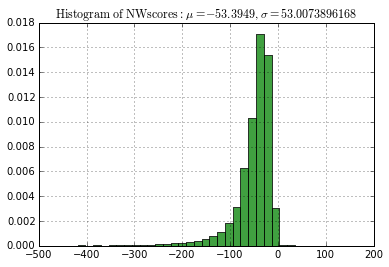

In [32]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(score_list, 100, normed=1, facecolor='green', alpha=0.75)
mu = np.mean(score_list)
sigma = np.std(score_list)
plt.title(r'$\mathrm{Histogram\ of\ NW scores:}\ \mu=' + str(mu) + ',\ \sigma=' + str(sigma) + '$')
# Note: there is a value lower, ths has cut some extremes
plt.axis([-500, 200, 0, 0.018])
plt.grid(True)

plt.show()